In [7]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

Viscocity

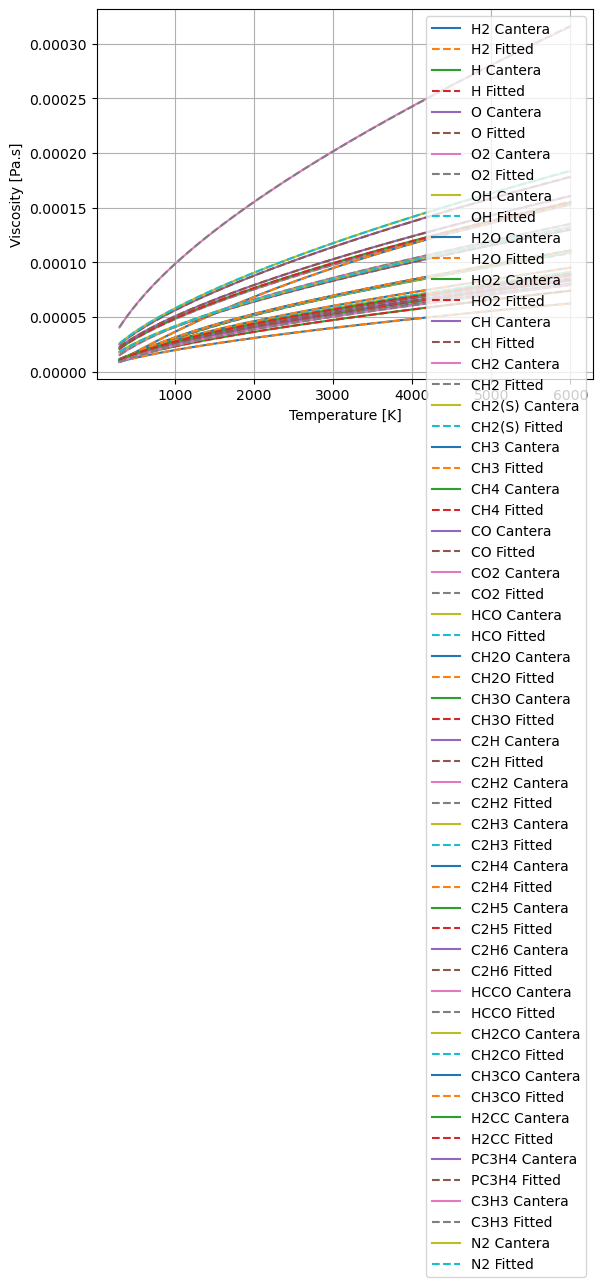

In [9]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
gas = ct.Solution("ffcmy9reduced30.yaml")
temp_arr = np.linspace(300, 6000, 1000)
output_file = "speciesMu"  # OpenFOAM dictionary output

header = r"""/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  1.0                                   |
|   \\  /    A nd           | Web:      http://www.openfoam.org               |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
version                         2.0;
format                          ascii;
class                           dictionary;
object                          speciesMu;
}

// Scheme: transport fitting
"""

with open(output_file, "w") as f:
    f.write(header + "\n")
    
    # Loop through each species
    for sp in gas.species_names:
        # Cantera viscosity polynomial coefficients
        v_coeffs = gas.get_viscosity_polynomial(gas.species_index(sp))
        mu_arr = np.polyval(v_coeffs[::-1], np.log(temp_arr))**2 * np.sqrt(temp_arr)
        
        # Fit log(mu/0.1) to 3rd-degree polynomial in log(T)
        X = np.vander(np.log(temp_arr), 4)
        y = np.log(mu_arr / 0.1)
        beta = np.linalg.solve(X.T @ X, X.T @ y)
        
        # Write to file in OpenFOAM Mu format
        f.write(f"{sp}\n{{\n")
        for i, b in enumerate(beta[::-1], start=1):
            f.write(f"Mu{i}\t{b:.3E}\t;\n")
        f.write("}\n\n")
        
        # Optional: plot each species for verification
        y_fit = X @ beta
        mu_fit = np.exp(y_fit) * 0.1
        plt.plot(temp_arr, mu_arr, label=f'{sp} Cantera')
        plt.plot(temp_arr, mu_fit, '--', label=f'{sp} Fitted')

plt.xlabel('Temperature [K]')
plt.ylabel('Viscosity [Pa.s]')
plt.legend()
plt.grid(True)
plt.show()


Thermal Conductivity

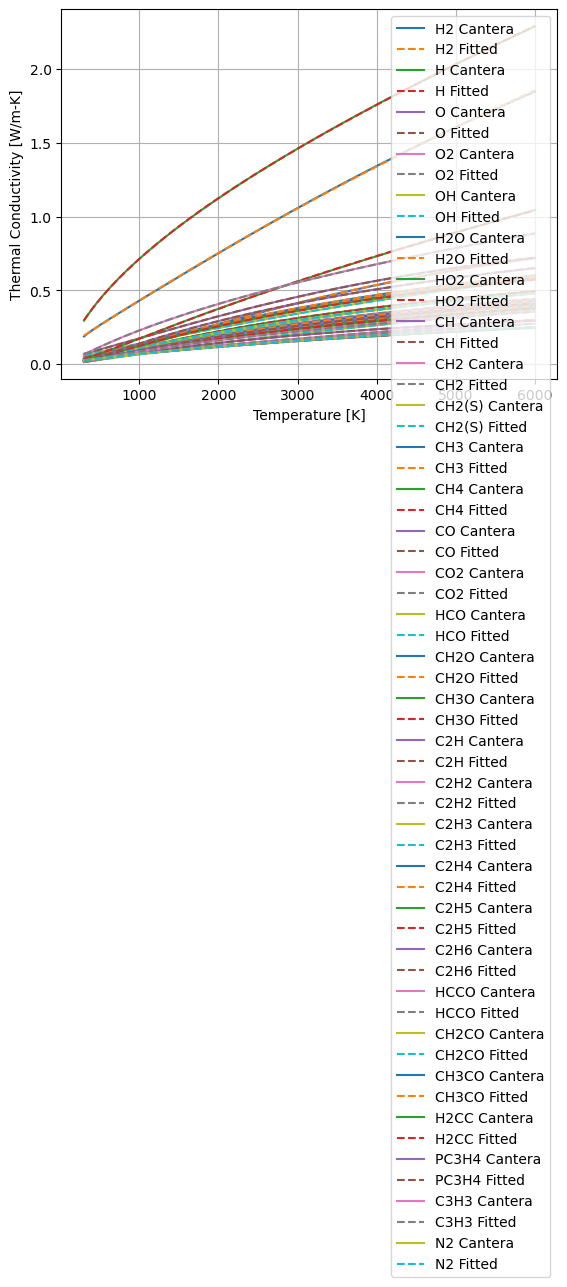

In [11]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

# --- Inputs ---
gas = ct.Solution("ffcmy9reduced30.yaml")
temp_arr = np.linspace(300, 6000, 1000)  # Use 300-6000 K to match previous format
output_file = "speciesLambda"  # OpenFOAM dictionary output

header = r"""/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  1.0                                   |
|   \\  /    A nd           | Web:      http://www.openfoam.org               |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
version                         2.0;
format                          ascii;
class                           dictionary;
object                          speciesLambda;
}

// Scheme: transport fitting
// Fitted by Josh Lipman for FFCM2 Hydrogen Submechanism. 6/16/2025
// See polynomialfits.ipynb in stanford_collaboration
// Temperature range is 300 to 6000
"""

with open(output_file, "w") as f:
    f.write(header + "\n")
    
    # Loop through each species
    for sp in gas.species_names:
        # Get Cantera thermal conductivity polynomial coefficients
        tc_coeffs = gas.get_thermal_conductivity_polynomial(gas.species_index(sp))
        tc_arr = np.polyval(tc_coeffs[::-1], np.log(temp_arr)) * np.sqrt(temp_arr)
        
        # Fit log(tc / 1e-5) to 3rd-degree polynomial in log(T)
        X = np.vander(np.log(temp_arr), 4)
        y = np.log(tc_arr / 1e-5)
        beta = np.linalg.solve(X.T @ X, X.T @ y)
        
        # Write to file in OpenFOAM Lambda format
        f.write(f"{sp}\n{{\n")
        for i, b in enumerate(beta[::-1], start=1):
            f.write(f"Lambda{i}\t {b:.3E}\t;\n")
        f.write("}\n\n")
        
        # Optional plotting for verification
        y_fit = X @ beta
        tc_fit = np.exp(y_fit) * 1e-5
        plt.plot(temp_arr, tc_arr, label=f'{sp} Cantera')
        plt.plot(temp_arr, tc_fit, '--', label=f'{sp} Fitted')

plt.xlabel('Temperature [K]')
plt.ylabel('Thermal Conductivity [W/m-K]')
plt.legend()
plt.grid(True)
plt.show()


Binary Diffusion Coefficients

In [ ]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

# --- Inputs ---
gas = ct.Solution("ffcmy9reduced30.yaml")
temp_arr = np.linspace(300, 6000, 1000)  # Match previous range
output_file = "binaryDiff"

header = r"""/*---------------------------------------------------------------------------*\
| =========                 |                                                 |
| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\    /   O peration     | Version:  1.0                                   |
|   \\  /    A nd           | Web:      http://www.openfoam.org               |
|    \\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{
version                         2.0;
format                          ascii;
class                           dictionary;
object                          binaryDiff;
}

// Scheme: transport fitting
// Fitted by Josh Lipman for FFCM2 Hydrogen Submechanism. 6/16/2025
// See polynomialfits.ipynb in stanford_collaboration
// Temperature range is 300 to 6000
"""

with open(output_file, "w") as f:
    f.write(header + "\n")
    
    # Loop over all combinations of species (including self-pairs)
    for i, j in combinations_with_replacement(range(gas.n_species), 2):
        sp1 = gas.species_names[i]
        sp2 = gas.species_names[j]
        
        # Cantera binary diffusion coefficients polynomial
        diff_coeffs = gas.get_binary_diff_coeffs_polynomial(i, j)
        diff_arr = np.polyval(diff_coeffs[::-1], np.log(temp_arr)) * temp_arr ** 1.5 / gas.P
        
        # Fit log(diff / 1e-4) vs log(T) to 3rd-degree polynomial
        X = np.vander(np.log(temp_arr), 4)
        y = np.log(diff_arr / 1e-4)
        beta = np.linalg.solve(X.T @ X, X.T @ y)
        
        # Write to OpenFOAM dictionary
        f.write(f"{sp1}-{sp2}\n{{\n")
        for k, b in enumerate(beta[::-1], start=1):
            f.write(f"Diff{k}\t{b:.3E}\t;\n")
        f.write("}\n\n")
        
        # Optional plotting for verification
        y_fit = X @ beta
        diff_fit = np.exp(y_fit) * 1e-4
        plt.plot(temp_arr, diff_arr, label=f'{sp1}-{sp2} Cantera')
        plt.plot(temp_arr, diff_fit, '--', label=f'{sp1}-{sp2} Fitted')

plt.xlabel('Temperature [K]')
plt.ylabel('Binary Diffusion Coefficient [m^2/s]')
plt.legend(fontsize=6, ncol=3)
plt.grid(True)
plt.show()
